# Hate Speech - Time series analysis


## Imports


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

## Utility functions


Extract time-series from the raw dataset


In [2]:
def get_time_series(data: dict, indicator: str) -> pd.DataFrame:
    """
    Extracts a time series for a given indicator from the DataFrame.

    :param df: DataFrame containing the data.
    :param indicator: The indicator to extract.
    :return: DataFrame with the time series for the specified indicator.
    """
    # Extract data
    dates = data[indicator]["DATE"]
    scores = data[indicator]["SENTIMENT_SCORE"]
    volume = data[indicator]["TOTAL_COUNT"]
    
	# Build the DataFrame
    df_sentiment = pd.DataFrame(
        {"date": pd.to_datetime(dates), "sentiment_score": scores, "volume": volume}
    )

    # Arrondamento dei valori di sentiment_score a 4 decimali
    df_sentiment["sentiment_score"] = df_sentiment["sentiment_score"].round(4)

    return df_sentiment

Build normalized index

In [3]:
def get_normalized_time_series(df: pd.DataFrame, base_year: int, year_range: list[int] = [2018, 2019, 2020, 2021, 2022]) -> pd.DataFrame:
    
	# Normalizes the sentiment scores in the DataFrame based on a base year.
	df["year"] = df["date"].dt.year
	base = df[df["year"] == base_year]["sentiment_score"].mean()

	# Calculate normalized sentiment index
	df_filtered = df[df["year"].isin(year_range)][["date", "year", "sentiment_score"]].copy()
	df_filtered["normalized_index"] = 100 + ((df_filtered["sentiment_score"] - base) / abs(base)) * 100

	# Arrondamento dei valori di sentiment_score a 4 decimali
	df_filtered["normalized_index"] = df_filtered["normalized_index"].round(4)

	# Calcolo della media mobile a 14 giorni dell'indice normalizzato
	# df_filtered["rolling_14d"] = df_filtered["normalized_index"].rolling(window=14, center=True).mean()

	# Calcolo della media mobile a 7 giorni dell'indice normalizzato
	df_filtered["rolling_7d"] = df_filtered["normalized_index"].rolling(window=7, center=True).mean()

	# Arrondamento dei valori di sentiment_score a 4 decimali
	df_filtered["rolling_7d"] = df_filtered["rolling_7d"].round(4)

	# Calcolo della media mensile dell'indice normalizzato
	# df_filtered["month"] = df_filtered["date"].dt.to_period("M")
	# monthly_avg = df_filtered.groupby("month")["normalized_index"].mean().reset_index()
	# monthly_avg["month"] = monthly_avg["month"].dt.to_timestamp()

	return df_filtered



Filter the dataset by a specified period

In [4]:
# Filtra il DataFrame df_filtered per anno e mese di inizio/fine
def filter_by_period(df, year_start, month_start, year_end, month_end):
    start = pd.Timestamp(year=year_start, month=month_start, day=1)
    # Trova l'ultimo giorno del mese di fine
    end = pd.Timestamp(year=year_end, month=month_end, day=1) + pd.offsets.MonthEnd(0)
    return df[(df["date"] >= start) & (df["date"] <= end)]

---


## Global variables (specify the semantic group to analyze)

In [ ]:
SEMANTIC_GROUP = "immigra" #immigra, stranier, clandestin

---

## Data pre-processing


### Read dashboard dataset (file .json)


In [5]:
# Percorso del file raw (questo file è l'input della dashboard)
file_path = "data/hate_speech_raw.json"

# Caricamento del file JSON
with open(file_path, "r") as f:
    data = json.load(f)

### Extract the time series from the raw dataset


In [ ]:
df_sentiment = get_time_series(data, "-")
df_semantic = get_time_series(data, SEMANTIC_GROUP)

### Save time-series (date, sentiment_score, volume) in .csv


In [ ]:
csv_path = "data/hate_speech_sentiment.csv"
df_sentiment.to_csv(csv_path, index=False)

csv_semantic_path = f"data/hate_speech_{SEMANTIC_GROUP}_sentiment.csv"
df_semantic.to_csv(csv_semantic_path, index=False)

---


## Volume series (2018 - 2022)


Moving average


In [8]:
# Calcolo della media mobile a 14 giorni dell'indice normalizzato
df_sentiment["volume_rolling_14d"] = df_sentiment["volume"].rolling(window=14, center=True).mean()
df_semantic["volume_rolling_14d"] = df_semantic["volume"].rolling(window=14, center=True).mean()

### Plot the volume series

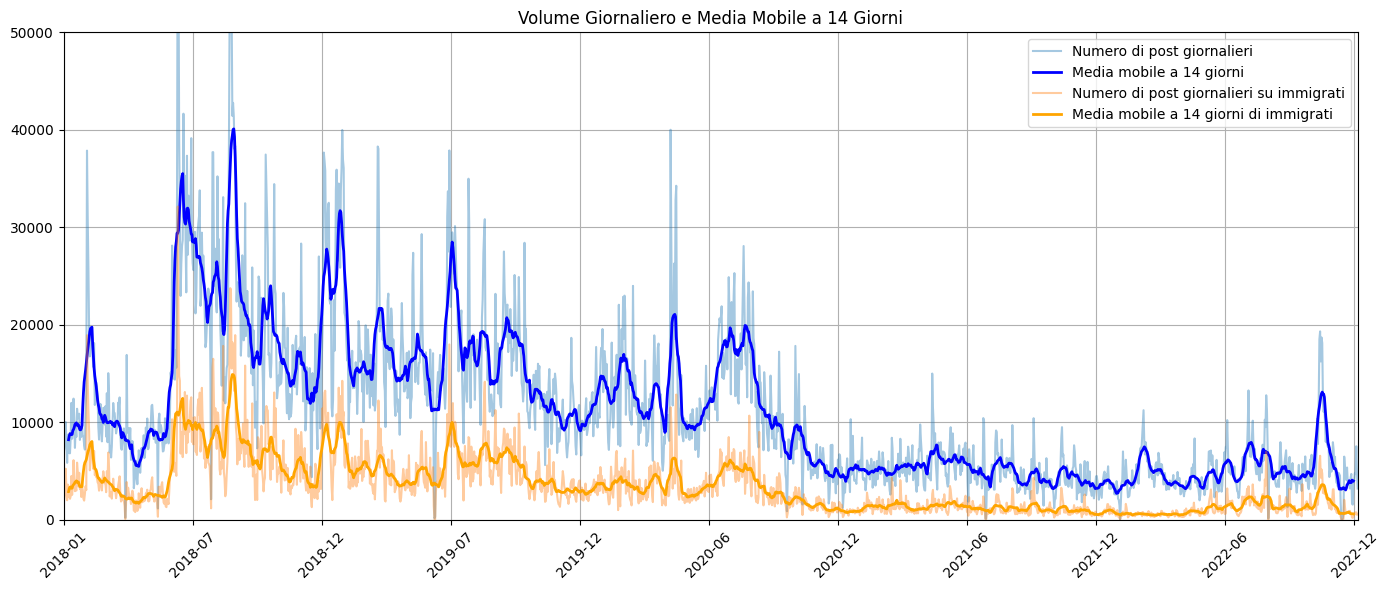

In [9]:
# Limiti temporali
start_date = df_sentiment["date"].min()
end_date = df_sentiment["date"].max()

# Tick ogni 6 mesi, incluso dicembre 2022
tick_dates = mdates.drange(
    start_date, end_date + timedelta(days=31), timedelta(days=182)
)

plt.figure(figsize=(14, 6))

plt.plot(
    df_sentiment["date"],
    df_sentiment["volume"],
    label="Numero di post giornalieri",
    alpha=0.4,
)

plt.plot(
    df_sentiment["date"],
    df_sentiment["volume_rolling_14d"],
    label="Media mobile a 14 giorni",
    color="blue",
    linewidth=2,
)

plt.plot(
    df_semantic["date"],
    df_semantic["volume"],
    label="Numero di post giornalieri su immigrati",
    alpha=0.4,
)

plt.plot(
    df_semantic["date"],
    df_semantic["volume_rolling_14d"],
    label="Media mobile a 14 giorni di immigrati",
    color="orange",
    linewidth=2,
)

# Esempio: linea soglia per riferimento (opzionale)
# plt.axhline(y=10000, color='black', linestyle='--', linewidth=1.5, label='Soglia riferimento')

plt.ylim(0, 50000)
plt.xlim(start_date, end_date)

# Formattazione asse x
plt.gca().set_xticks(tick_dates)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.title("Volume Giornaliero e Media Mobile a 14 Giorni")
# plt.xlabel("Data")
# plt.ylabel("Volume Giornaliero")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("charts/hs_volume_giornaliero", dpi=300, bbox_inches="tight")

plt.show()

---


## Sentiment index (2018 - 2022)


Get normalized index and normalized moving average (2018 - 2022)


In [10]:
df_sentiment_normalized = get_normalized_time_series(df_sentiment, 2018)
df_semantic_normalized = get_normalized_time_series(df_semantic, 2018)

Filter in order to display only the specified time range

In [11]:
df_sentiment_normalized_filtered = filter_by_period(df_sentiment_normalized, 2022, 10, 2022, 12)
df_semantic_normalized_filtered = filter_by_period(df_semantic_normalized, 2022, 10, 2022, 12)

### Plot the sentiment index

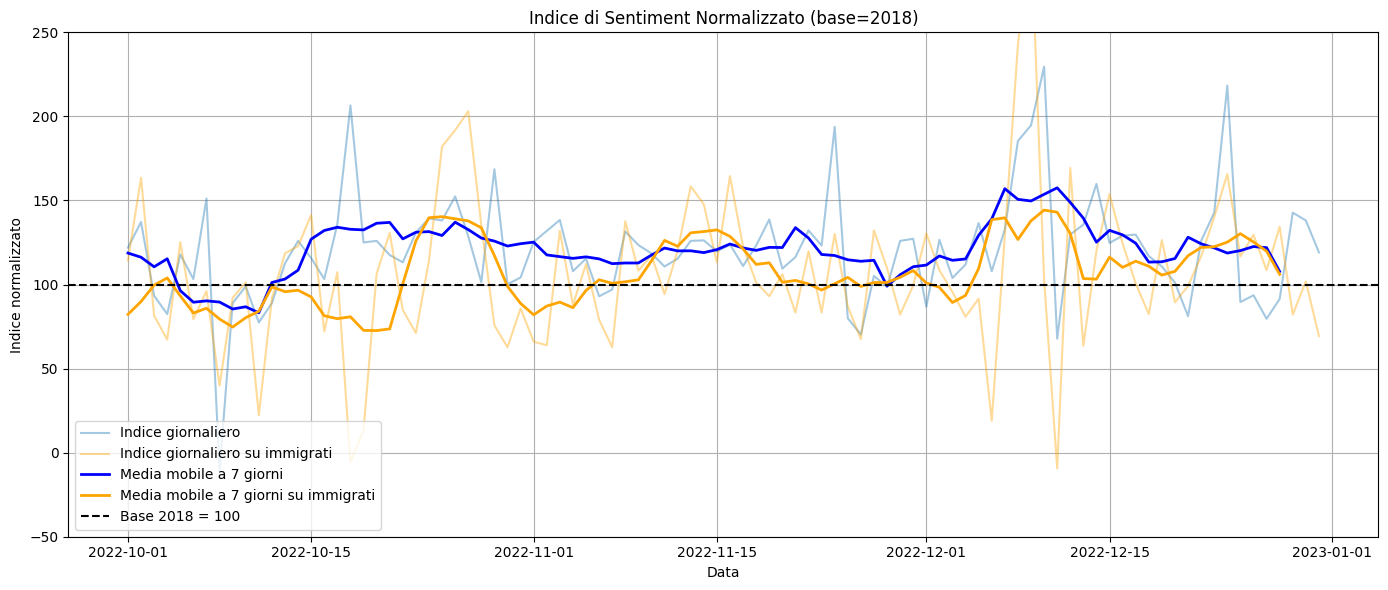

In [12]:
# Imposta i limiti min e max
start_date = df_sentiment_normalized_filtered["date"].min()
end_date = df_sentiment_normalized_filtered["date"].max()

# Genera i tick ogni 6 mesi, incluso l'ultimo
# tick_dates = mdates.drange(start_date, end_date + timedelta(days=31),
# timedelta(days=182))  # ~6 mesi


# Genera i tick ogni mese, incluso l'ultimo
tick_dates = mdates.drange(
    start_date, end_date + timedelta(days=31), timedelta(days=30)
)  # ~1 mesi

# Grafico
plt.figure(figsize=(14, 6))
plt.plot(
    df_sentiment_normalized_filtered["date"],
    df_sentiment_normalized_filtered["normalized_index"],
    label="Indice giornaliero",
    alpha=0.4,
)

plt.plot(
    df_semantic_normalized_filtered["date"],
    df_semantic_normalized_filtered["normalized_index"],
    label="Indice giornaliero su immigrati",
    color="orange",
    alpha=0.4,
)



# plt.plot(df_filtered["date"], df_filtered["rolling_14d"], label="Media mobile a 14 giorni", color="blue", linewidth=2)
plt.plot(
    df_sentiment_normalized_filtered["date"],
    df_sentiment_normalized_filtered["rolling_7d"],
    label="Media mobile a 7 giorni",
    color="blue",
    linewidth=2,
)

plt.plot(
    df_semantic_normalized_filtered["date"],
    df_semantic_normalized_filtered["rolling_7d"],
    label="Media mobile a 7 giorni su immigrati",
    color="orange",
    linewidth=2,
)


plt.axhline(
    y=100, color="black", linestyle="--", linewidth=1.5, label="Base 2018 = 100"
)


plt.ylim(-50, 250)
# plt.xlim(start_date, end_date)

# Imposta i tick personalizzati
# plt.gca().set_xticks(tick_dates)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.xticks(rotation=45)

plt.title("Indice di Sentiment Normalizzato (base=2018)")
plt.xlabel("Data")
plt.ylabel("Indice normalizzato")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()

plt.savefig("charts/hs_indice_sentiment_normalizzato.png", dpi=300, bbox_inches="tight")

plt.show()